Imports of the Python libraries I employed in this notebook:

In [1]:
import pandas as pd 
import datetime as dt
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt

%config Completer.use_jedi = False

Constants used to peramiterize the trajectories. The maximum time gap between each data point is 200 seconds, and the top 15 longest trajectories from each shark were selected. 

In [2]:
# minimum time gap in trajectory
time_gap = 200
# top longest shark trajectories
top_shark_trajs = 15

The imported CSV data file:

In [3]:
data = pd.read_csv("jws_vps_dat_May-Dec_2020.csv") 

Teaching the program to interpret date and time:

In [4]:
data['DateTimeUTC'] = data['DateTimeUTC'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

List of all sharks tagged: 

In [5]:
sharks = data['shark'].unique()
sharks

array(['2020-21', '2020-20', '2020-19', '2020-31', '2020-32', '2020-33',
       '2020-13', '2020-12', '2020-16', '2020-10', '2020-17', '2020-15',
       '2020-22', '2020-04', '2020-37', '2020-34', '2020-35_2', '2020-36',
       '2020-40', '2020-35', '2020-41', '2020-42', '2020-43', '2020-44',
       '2020-45', '2020-18', '2020-29'], dtype=object)

List of all sharks with sex labled. M for male, F for female, U for unidentified

In [6]:
for n in sharks:
    print(n, data.loc[data['shark'] == n].iloc[0].sex)

2020-21 U
2020-20 M
2020-19 M
2020-31 F
2020-32 F
2020-33 U
2020-13 F
2020-12 F
2020-16 F
2020-10 U
2020-17 F
2020-15 F
2020-22 F
2020-04 F
2020-37 U
2020-34 U
2020-35_2 nan
2020-36 U
2020-40 U
2020-35 F
2020-41 U
2020-42 F
2020-43 F
2020-44 F
2020-45 F
2020-18 F
2020-29 U


List of all male and female sharks (excluding unidentified sharks).

In [7]:
female_sharks = []
male_sharks = []
for n in sharks:
    if (data.loc[data['shark'] == n].iloc[0].sex == 'F'):
        female_sharks.append(n)
    if (data.loc[data['shark'] == n].iloc[0].sex == 'M'):
        male_sharks.append(n)

female_sharks, male_sharks

(['2020-31',
  '2020-32',
  '2020-13',
  '2020-12',
  '2020-16',
  '2020-17',
  '2020-15',
  '2020-22',
  '2020-04',
  '2020-35',
  '2020-42',
  '2020-43',
  '2020-44',
  '2020-45',
  '2020-18'],
 ['2020-20', '2020-19'])

In [8]:
shark_data  = data.loc[data['shark'] == '2020-21'].sort_values(by='DateTimeUTC').to_numpy()

Function that chunks the trajectories so that the time intervals between each data point is 200 seconds or less. 

In [9]:
def chunk_data(data, seconds):
    sub = []
    results = []
    for idx, n in enumerate(data):
        if (idx < len(data) - 1):
            delta = (data[idx + 1][1] - data[idx][1]).seconds
            if (delta < seconds):
                sub.append(data[idx])
            else:
                # Don't forget the last one
                sub.append(data[idx])
                results.append(sub)
                sub = []
    return results

Function that takes the matplotlib canvases (images) and turns them into two dimensional arrays of 1s and 0s. (1 indicates that a shark is plotted, 0 indicates no shark is plotted). 

In [10]:
def canvas2binary_array(canvas):
    canvas.draw()
    plt_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    datalen = int(len(plt_array)/3)
    a = plt_array.reshape(datalen,3)
    data = np.zeros(datalen)

    cnt = int(0)

    for n in a:
        if (255 in n):
            data[cnt] = 0
        else:
            data[cnt] = 1
        cnt = cnt + 1
    w, h = fig.canvas.get_width_height()
    return data.reshape(h, w)

In [ ]:
This code cell chunks the female trajectories into individual plots according to time: 

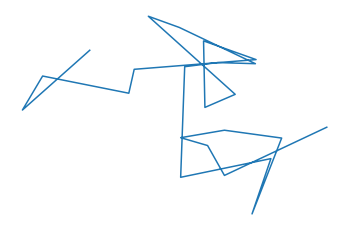

In [11]:
fig = plt.figure()

metafemalesharks = []

for s in female_sharks:
    shark_data  = data.loc[data['shark'] == s].sort_values(by='DateTimeUTC').to_numpy()
    chunked_shark_data = chunk_data(shark_data, time_gap)
    chunked_shark_data.sort(key = len)
    for n in range(-1,-top_shark_trajs, -1):
        sample = chunked_shark_data[n]
        times = [row[1] for row in sample]
        lats = [row[2] for row in sample]
        lons = [row[3] for row in sample]
        fig.clear(True)
        plt.plot(lats, lons)
        plt.axis('off')
        plt_array = canvas2binary_array(fig.canvas)
        metafemalesharks.append(plt_array)

metafemalesharks_array = np.asarray(metafemalesharks)

In [ ]:
Example female shark trajectory:

(210, 288, 432)


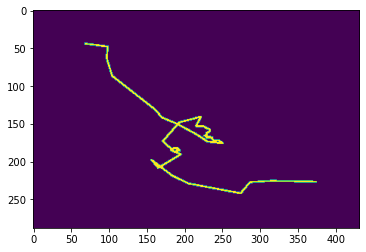

In [12]:
print(metafemalesharks_array.shape)
plt.imshow(metafemalesharks_array[20])

This code cell chunks the male trajectories into individual plots according to time: 

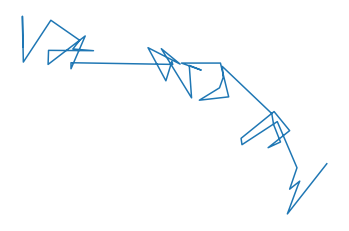

In [13]:
fig = plt.figure()
fig.clear(True)

metamalesharks = []

for s in male_sharks:
    shark_data  = data.loc[data['shark'] == s].sort_values(by='DateTimeUTC').to_numpy()
    chunked_shark_data = chunk_data(shark_data, time_gap)
    chunked_shark_data.sort(key = len)
    for n in range(-1,-top_shark_trajs, -1):
        sample = chunked_shark_data[n]
        times = [row[1] for row in sample]
        lats = [row[2] for row in sample]
        lons = [row[3] for row in sample]
        fig.clear(True)
        plt.plot(lats, lons)
        plt.axis('off')
        plt_array = canvas2binary_array(fig.canvas)
        metamalesharks.append(plt_array)

metamalesharks_array = np.asarray(metamalesharks)

Example male shark trajectory:

(28, 288, 432)


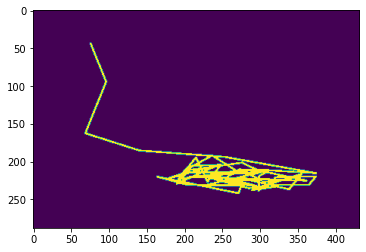

In [14]:
print(metamalesharks_array.shape)
plt.imshow(metamalesharks_array[10])

Training array of the CNN: 

In [15]:
metafemalesharks_array_train = metafemalesharks_array[1::2]
metamalesharks_array_train = metamalesharks_array[1::2]
metafemalesharks_array_test = metafemalesharks_array[2::2]
metamalesharks_array_test = metamalesharks_array[2::2]

metasharks_array_train = np.concatenate((metafemalesharks_array_train,metamalesharks_array_train), axis = 0)
metasharks_array_train.shape
sex_train = np.concatenate((np.zeros(metafemalesharks_array_train.shape[0]),np.ones(metamalesharks_array_train.shape[0])), axis = 0 )

metasharks_array_test = np.concatenate((metafemalesharks_array_test,metamalesharks_array_test), axis = 0)
metasharks_array_test.shape
sex_test = np.concatenate((np.zeros(metafemalesharks_array_test.shape[0]),np.ones(metamalesharks_array_test.shape[0])), axis = 0 )

In [ ]:
Testing array of the CNN:

In [16]:
sex_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [17]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))

2022-02-19 05:35:59.979267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-19 05:35:59.979394: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-19 05:35:59.979483: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-mayachastang): /proc/driver/nvidia/version does not exist
2022-02-19 05:35:59.980196: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(metasharks_array_train, sex_train, epochs=3)

2022-02-19 05:36:00.219905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
4/4 [==============================] - 2s 137ms/step - loss: 1.3513 - accuracy: 0.6807
Epoch 2/3
4/4 [==============================] - 1s 167ms/step - loss: 0.1759 - accuracy: 0.9328
Epoch 3/3
4/4 [==============================] - 1s 161ms/step - loss: 0.0194 - accuracy: 1.0000


In [19]:
val_loss,val_acc = model.evaluate(metasharks_array_test, sex_test)

4/4 [==============================] - 0s 13ms/step - loss: 0.6643 - accuracy: 0.8291
